In [187]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import tensorboard
from torch.utils.tensorboard import SummaryWriter

This is an attempt to build a RNN/LSTM model to predict stock prices

# Load data

In [188]:
data = pd.read_csv('MSFT.csv')
n_samples = len(data)
n_test_samples = int(n_samples/5)
n_train_samples = n_samples - n_test_samples
input_data = data.iloc[:,1:7].to_numpy()

print('number of samples:', n_samples)
data.Date = pd.to_datetime(data.Date)
data.head()

number of samples: 9187


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060980,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063158,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064247,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062613,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061524,47894400


## plot the stock prices

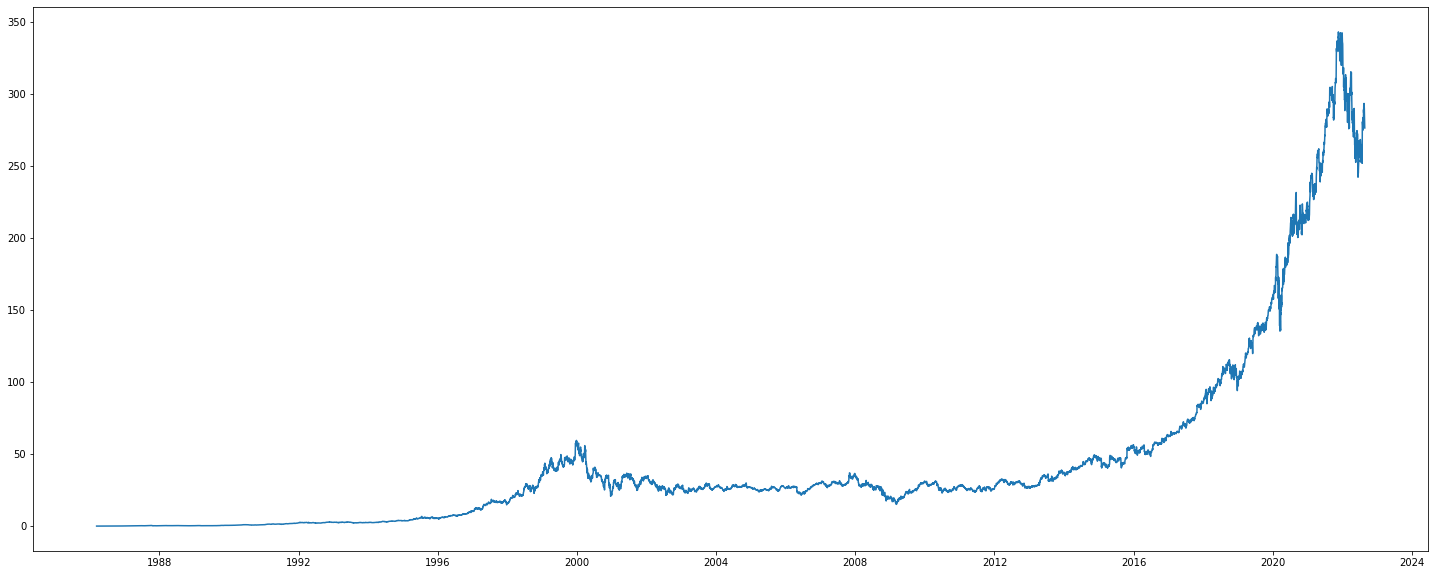

In [189]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(data.Date ,data.Close)

# Create Data transformer

In [190]:
class DataTransformer():
    def __init__(self,data):
        self.data_min = data.min(axis=0)
        self.data_max = data.max(axis=0)

    def __call__(self, data):
        return  (data - self.data_min) / (self.data_max - self.data_min)

data_transformer = DataTransformer(input_data)


## build datasets

In [191]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, filename: str, ws: int = 10, i_start: int = 0, i_end: int = None, transformer=None):
        """
        Initializes the data
        @param filename: Name of the csv file
        @param ws: window size
        @param i_start: index of the first data row
        @param i_end: index of the last data row
        """
        self.transformer = transformer
        np_array = pd.read_csv(filename).to_numpy()[i_start:i_end,1:7]
        if transformer :
            np_array = transformer(np_array)
        file_data = torch.from_numpy(np_array.astype(float))
        x = []
        labels = []
        for i in range(len(file_data)-ws):
            x.append(file_data[i:i+ws])
            labels.append(file_data[i+ws])
        self.data = torch.stack(x).type(torch.FloatTensor)
        self.labels = torch.stack(labels).type(torch.FloatTensor)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item], self.labels[item]



In [192]:
window_size = 15
batch_size = 64

train_dataset = Dataset('MSFT.csv',window_size,i_end=n_train_samples,transformer=data_transformer)
test_dataset = Dataset('MSFT.csv',window_size,i_start=n_train_samples,transformer=data_transformer)



# Define the model

In [193]:
class Model(nn.Module):
    def __init__(self,input_size=6,hidden_size=50,out_size=1,num_layers=1,batch_first=True):
        super(Model,self).__init__()
        self.hidden_size = hidden_size
        self.batch_first = batch_first
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size,hidden_size,num_layers,batch_first=batch_first)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = self.init_hidden(1)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.batch_size = 1
    def init_hidden(self,batch_size=1):
        self.batch_size = batch_size
        self.hidden = (torch.zeros((self.num_layers,batch_size,self.hidden_size)),torch.zeros((self.num_layers,batch_size,self.hidden_size)))

    def forward(self,x):
        out, self.hidden = self.rnn(x,self.hidden)
        #print('out-shape:',out.shape)
        #out = self.bn1(out.reshape(self.batch_size,self.hidden_size,window_size))
        out = self.layernorm(out)
        #print('out-shape:',out.shape)
        pred = self.linear(out.reshape(self.batch_size,window_size,self.hidden_size))
        return pred[:,-1]


# Initialize model

In [194]:
model = Model(num_layers=1)
model.init_hidden(batch_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
print(model)

Model(
  (rnn): LSTM(6, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layernorm): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
)


# Train the model

In [195]:
test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)
train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [196]:
start = time.time()
epochs = 50
writer = SummaryWriter(comment='With Layer Normalization')
j = 0
loss_sum = 0
model.train()
for i in range(epochs):
    for train_x, train_y in train_data_loader:
        if len(train_x) != batch_size:
            continue
        input_seq = train_x.reshape(batch_size,window_size,-1)
        model.init_hidden(batch_size=batch_size)
        optimizer.zero_grad()
        y_pred = model(input_seq)
        loss = criterion(y_pred,train_y[:,3].reshape(batch_size,-1))
        loss_sum += loss.item()
        j+=1
        loss.backward()
        optimizer.step()

    if i%(int(epochs/5)) == 0:
        writer.add_scalar('Loss',loss_sum/(epochs/5),j)
        end = time.time()
        print('Epoch: %d  Loss: %f  Elapsed time: %f'%(i,loss,end-start))
        loss_sum = 0

end = time.time()
print('finished in %f s' % (end-start))
writer.flush()
writer.close()


Epoch: 0  Loss: 0.000583  Elapsed time: 1.356393
Epoch: 10  Loss: 0.000007  Elapsed time: 13.893379
Epoch: 20  Loss: 0.000008  Elapsed time: 27.117930
Epoch: 30  Loss: 0.000017  Elapsed time: 40.401589
Epoch: 40  Loss: 0.000052  Elapsed time: 54.712016
finished in 67.118298 s


In [197]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

# Test prediction

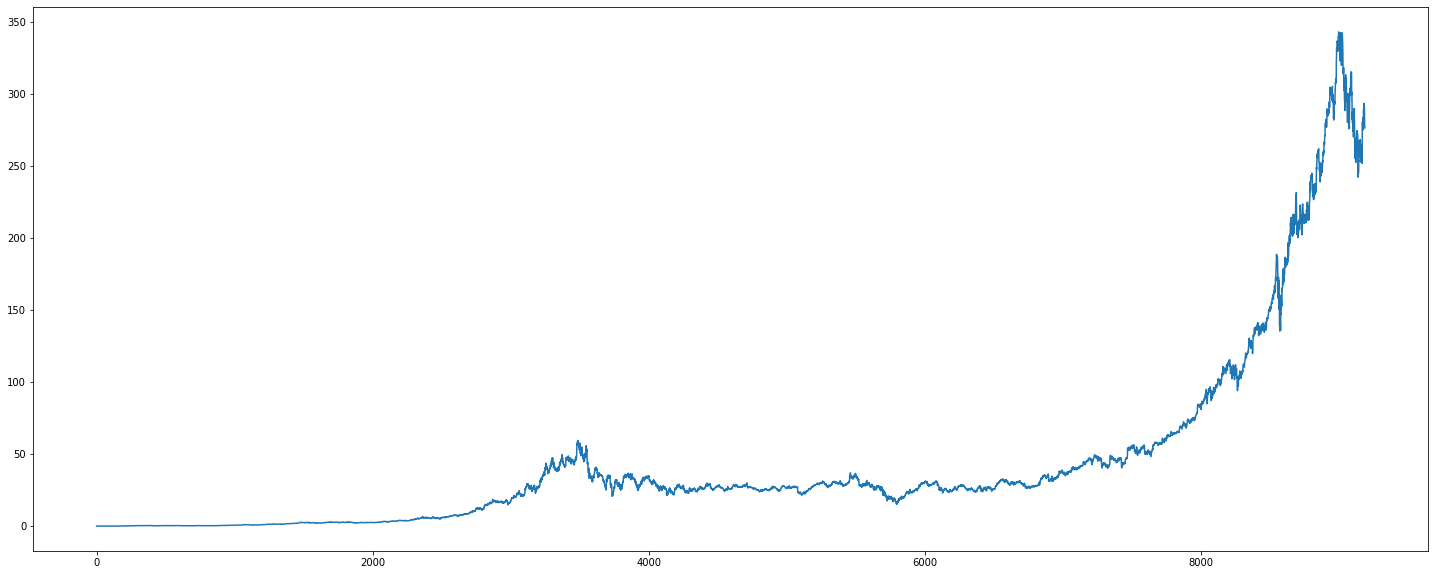

In [198]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(np.linspace(0,len(input_data),len(input_data)) ,input_data[:,3])

In [199]:
model.eval()
with torch.no_grad():
    model.init_hidden(len(test_dataset))
    y_pred = model(test_dataset[:][0])

In [200]:
y_pred.shape

torch.Size([1822, 1])

In [201]:
y = test_dataset[:][1][:,3]

In [202]:
len(y)

1822

In [203]:
len(train_dataset)

7335

(1.0, 1550.0)

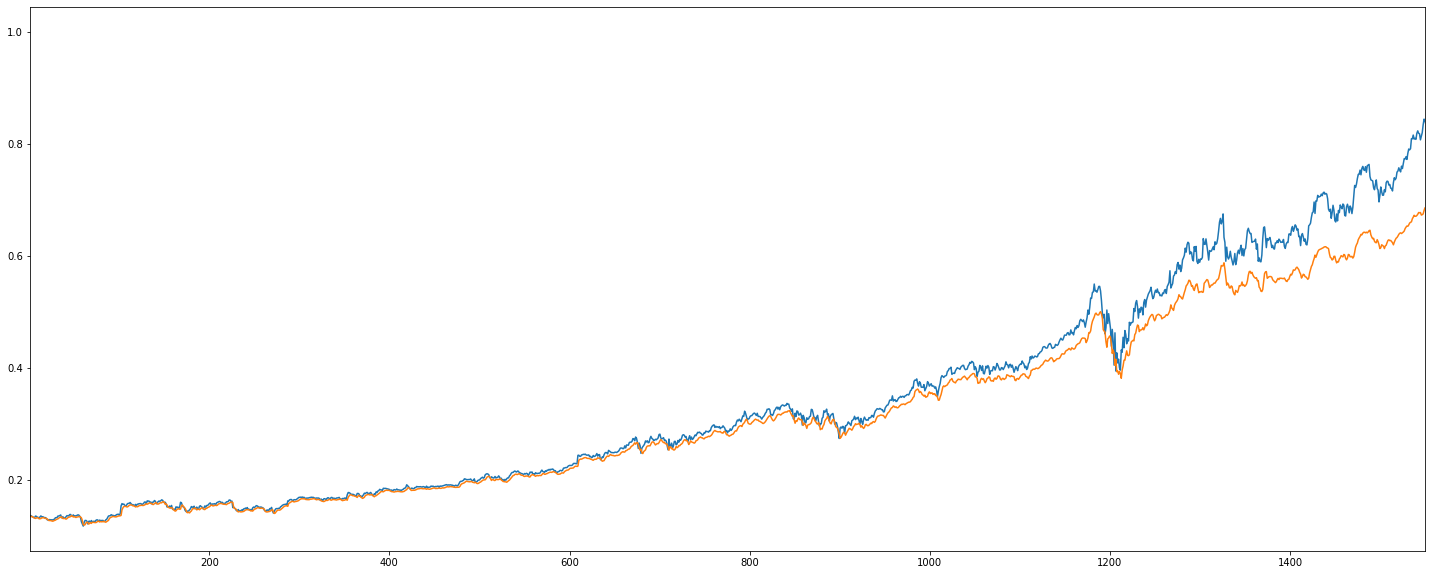

In [204]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(np.linspace(0,len(y),len(y)) ,y)
plt.plot(np.linspace(0,len(y),len(y)) ,y_pred.detach().numpy())
plt.xlim(1,1550)